### Preliminaries

In [46]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata


### Coordinate detection

In [35]:
def detect_dots(image_path):
    """
    Detect neon-green or red dots in an image using HSV thresholding + connected components.
    Creates an annotated image with numbered points and saves the coordinates to a CSV file.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # If image is rubik's cube
    if os.path.basename(image_path)[1] == 'r': 
        # Define HSV threshold range for red points; Note: red wraps around the hue range
        lower_red1 = np.array([0, 150, 150])
        upper_red1 = np.array([5, 255, 255])

        lower_red2 = np.array([170, 150, 150])
        upper_red2 = np.array([179, 255, 255])

        # Create masks for both red ranges
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

        # Combine masks
        mask = cv2.bitwise_or(mask1, mask2)

    #Image is tsai board 
    else:
        # Define HSV threshold range for neon green points
        lower_green = np.array([40, 100, 100])
        upper_green = np.array([80, 255, 255])

        # Apply threshold
        mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Connected components
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    points = []
    for i in range(1, num):  # skip background
        cx, cy = centroids[i]
        points.append((int(cx), int(cy)))

    df = pd.DataFrame(points, columns=["x0", "y0"])

    for i, (x, y) in enumerate(points):  
        # Draw a circle for the point
        cv2.circle(img, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        # Put text next to the point
        cv2.putText(img, str(i), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                2, (0, 0, 255), 3)

    # Save detected image in "detectedpics" folder
    filename = os.path.basename(image_path)
    imgname = os.path.splitext(filename)[0]
    output_folder = "detectedpics"
    os.makedirs(output_folder, exist_ok=True)
    img_out_path = os.path.join(output_folder, f"det_{imgname}.jpg")
    cv2.imwrite(img_out_path, img)


    #cv2.imshow("Annotated", img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    csv_path = os.path.join("detections", f"{imgname}.csv")
    df.to_csv(csv_path, index=False)
    return df.head()

In [36]:
for files in os.listdir('pics'):
    if files.endswith('.jpg'):
        detect_dots(os.path.join('pics', files))



In [37]:
print(pd.read_csv('detections/3r.csv').head())

    x0    y0
0  436  1323
1  520  1329
2  598  1351
3  670  1354
4  575  1368


In [7]:
img = cv2.imread('moreannopics/3.jpg')
if img is None:
    raise ValueError("Could not read image: moreannopics/3.jpg")
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

print(hsv)  

[[[ 30  10 197]
  [ 30  10 203]
  [ 30  10 206]
  ...
  [ 35   8 188]
  [ 35   8 190]
  [ 35   8 191]]

 [[ 30  10 201]
  [ 30  10 205]
  [ 30  10 208]
  ...
  [ 35   8 188]
  [ 35   8 186]
  [ 35   8 182]]

 [[ 30  10 205]
  [ 30  10 208]
  [ 30  10 209]
  ...
  [ 35   8 190]
  [ 35   8 190]
  [ 35   8 190]]

 ...

 [[  9 100 123]
  [  9 100 122]
  [  9 101 121]
  ...
  [ 30   3 187]
  [ 30   3 187]
  [ 30   3 188]]

 [[  9 101 121]
  [  9 102 120]
  [  9 103 119]
  ...
  [ 30   3 187]
  [ 30   3 187]
  [ 30   3 186]]

 [[  9 100 122]
  [  9 101 121]
  [  9 103 119]
  ...
  [ 30   3 185]
  [ 30   3 185]
  [ 30   3 185]]]


### 3D Recreation

In [ ]:
df1 = detect_green_dots('moreannopics/3.jpg')
df2 = detect_green_dots('moreannopics/5.jpg')

df1['x1'] = df2['x0']
df1 = df1[['y0', 'x0', 'x1']]

df1 = df1[10:40] 
df1

In [23]:
arr0 = df1['y0'].to_numpy()
arr1 = df1['x0'].to_numpy()
arr2 = df1['x1'].to_numpy()

arr0 = np.reshape(arr0, (6, 5))
arr1 = np.reshape(arr1, (6, 5))
arr2 = np.reshape(arr2, (6, 5))

In [27]:
arr1

array([[ 336,  638,  894,  210, 1004],
       [ 640,  335,  895,  638,  215],
       [1007,  338,  894,  639,  219],
       [1005,  339,  895,  637,  217],
       [1007,  340,  895,  641, 1006],
       [ 221,  342,  899,  638,  689]], dtype=int64)

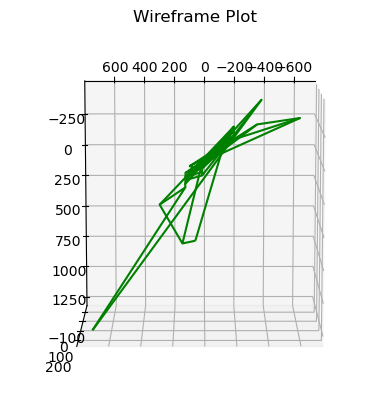

In [25]:
# focal length of camera
f = 200
# camera transverse distance
b = 100
# position of points in reference images
num_pts = 10
c = 128

# convert to numpy arrays
x1 = arr1
x2 = arr2
y = arr0
# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='green')
ax.set_title('Wireframe Plot')

ax.view_init(100, 90, 0)
plt.show()

## 3D Recreation with Surface

### Image 3 and 5

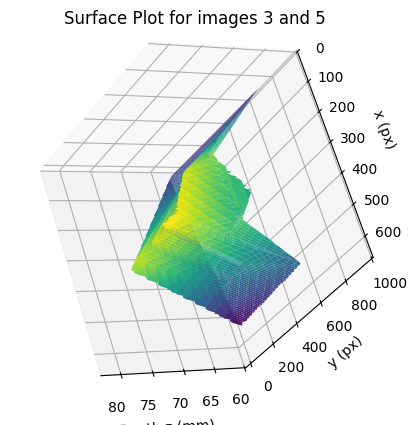

In [74]:
# focal length of camera
f = 200
# camera transverse distance
b = 100
# position of points in reference images
num_pts = 10
c = 128

x1 = pd.read_csv('detections/3.csv')['x0'].to_numpy()
y = pd.read_csv('detections/3.csv')['y0'].to_numpy()
x2 = pd.read_csv('detections/5.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[32], x2[31] = x2[31], x2[32]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 5')

ax.view_init(35, 60, 90)


plt.show()

### Image 3 and 4

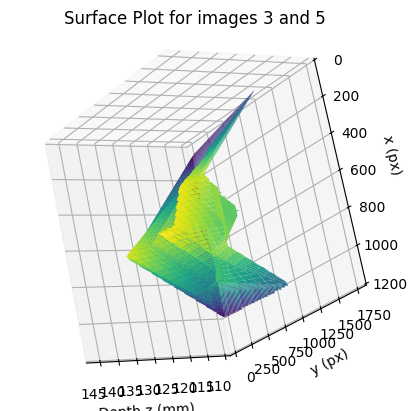

In [ ]:
#Try it for image 4
x2 = pd.read_csv('detections/4.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 4')

ax.view_init(35, 70, 90)


plt.show()

In [ ]:
x1 = pd.read_csv('detections/3.csv')['x0'].to_numpy()
x2 = pd.read_csv('detections/5.csv')['x0'].to_numpy()
print(x1)
print(x2-x1)


[ 253 1975 1191  627 1670 1195  627 1672 1191  632 1670 1193  634 1672
 1190  636 1672 1197  639 1679 1191 1287  980 1489  976 1496  634 1672
  965 1489 1279 1993  253]
[  315   333   254   292   301   249   293   295   253   289   295   248
   286   289   249   285   288   242   282   278   244   -50   590   267
   248   265   285   283   258   263   277 -1422  2039]
